-----------
## Initialization
We import all necessary modules and data. We also start a timer to keep track of overall execution time

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statistics import mean
import scipy.stats as stats
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from faker import Faker
import random

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

In [2]:
total_start = time.time()
df = pd.read_csv("StockMarketData2015-2023.csv")
df.rename(columns={"Date ":"Date"}, inplace=True) #For later convenience
df.rename(columns={"Open ":"Open"}, inplace=True)
df.rename(columns={"High ":"High"}, inplace=True)
df.rename(columns={"Low ":"Low"}, inplace=True)
df.rename(columns={"Close ":"Close"}, inplace=True)
df.rename(columns={"Shares Traded ":"Shares Traded"}, inplace=True)
df.rename(columns={"Turnover (₹ Cr)":"Turnover (Crores)"}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y', errors='coerce')

We rename the above columns to make it more convenient to call them at a later point.

----------------------
## Initial EDA
We perform basic EDA to learn the basic structure and contents of our dataset. We also visualize trends that may be present, to help us better preprocess our data.

In [3]:
#Exploratory Data Analysis
def eda(df, skipvisual=False):
    print("Head:")
    display(df.head(10))
    print("=========================")
    print("Info:",df.info(),"=========================")
    print("Description:")
    display(df.describe())
    print("=========================")
    print("Null values\n", df.isnull().sum(),"\n=========================")
    print("Dupicates:", df.duplicated().sum(),"\n=========================")
    
    if skipvisual: return
    
    col = len(df.columns)
    
    sns.pairplot(df, height=3)
    plt.show()
    
    df.hist(figsize=(col,col))
    plt.show()
    
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(col,col))
    sns.heatmap(corr, annot=True, cmap="coolwarm")
    plt.show()


In [4]:
eda(df, skipvisual=True)

Head:


Date     Open     High      Low    Close  Shares Traded  \
0 2015-11-09  7788.25  7937.75  7771.70  7915.20    218422388.0   
1 2015-11-10  7877.60  7885.10  7772.85  7783.35    170267413.0   
2 2015-11-11  7838.80  7847.95  7819.10  7825.00     22380435.0   
3 2015-11-13  7762.45  7775.10  7730.90  7762.25    165876819.0   
4 2015-11-16  7732.95  7838.85  7714.15  7806.60    154134885.0   
5 2015-11-17  7848.75  7860.45  7793.00  7837.55    149451211.0   
6 2015-11-18  7823.15  7843.40  7725.05  7731.80    148037721.0   
7 2015-11-19  7788.50  7854.90  7765.45  7842.75    136702518.0   
8 2015-11-20  7841.90  7906.95  7817.80  7856.55    156610433.0   
9 2015-11-23  7869.50  7877.50  7825.20  7849.25    130871603.0   

   Turnover (Crores)  
0            9376.17  
1            7153.47  
2            1123.44  
3            7731.55  
4            6871.15  
5            6367.14  
6            6112.32  
7            7410.15  
8            7298.01  
9            6099.09

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2015 non-null   datetime64[ns]
 1   Open               2015 non-null   float64       
 2   High               2015 non-null   float64       
 3   Low                2015 non-null   float64       
 4   Close              2015 non-null   float64       
 5   Shares Traded      2016 non-null   float64       
 6   Turnover (Crores)  2016 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 110.5 KB
Info: None =========================
Description:


Open          High           Low         Close  Shares Traded  \
count   2015.000000   2015.000000   2015.000000   2015.000000   2.016000e+03   
mean   12787.490422  12846.039628  12705.877494  12777.806526   3.456061e+08   
std     3750.801141   3762.940140   3733.227662   3749.762207   2.005378e+08   
min     7023.650000   7034.200000   6825.800000   6970.600000   1.661087e+07   
25%     9952.250000   9995.825000   9893.875000   9953.700000   2.088520e+08   
50%    11476.850000  11530.150000  11411.100000  11462.200000   2.728263e+08   
75%    16868.050000  17006.975000  16773.625000  16879.325000   4.387443e+08   
max    20156.450000  20222.450000  20129.700000  20192.350000   1.811564e+09   

       Turnover (Crores)  
count        2016.000000  
mean        19413.373413  
std          9720.969395  
min           805.890000  
25%         11275.430000  
50%         18449.160000  
75%         24821.275000  
max         78522.930000

Null values
 Date                 4
Open                 4
High                 4
Low                  4
Close                4
Shares Traded        3
Turnover (Crores)    3
dtype: int64 
Dupicates: 44 


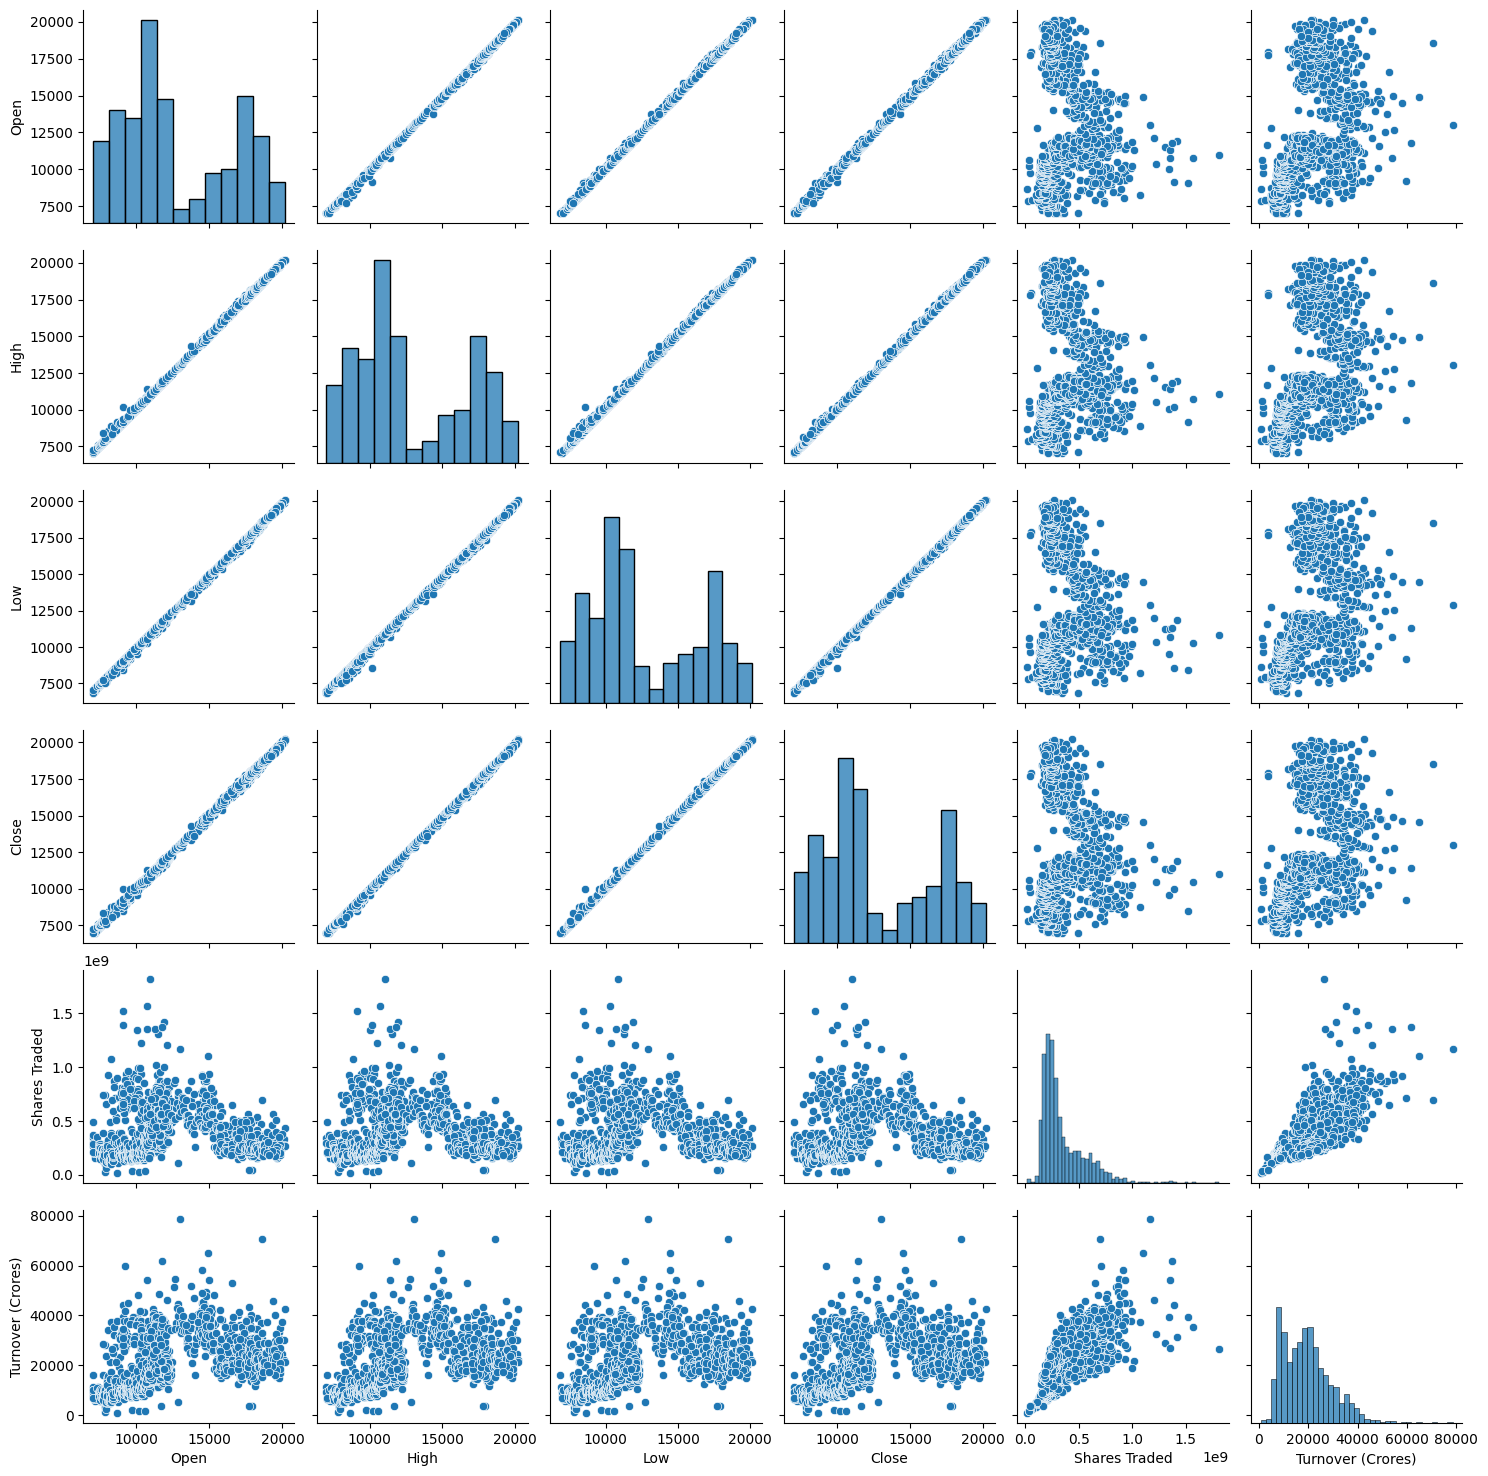

In [5]:
#visualise the data
sns.pairplot(df)
plt.show()

The pairplot reveals the pairwise relationships between numerical features in the dataset. Diagonal plots depict the distribution of each feature, while off-diagonal plots show scatter plots between feature pairs. Observations indicate strong positive correlations between `Open`, `High`, `Low`, and `Close`, indicating a consistent upward trend. A moderate positive correlation exists between `Shares Traded` and `Turnover (₹ Cr)`, implying a rise in trading volume alongside an increase in total traded value. The weak positive correlation between Date and other features suggests an overall upward trend in stock prices over the past 5 years.


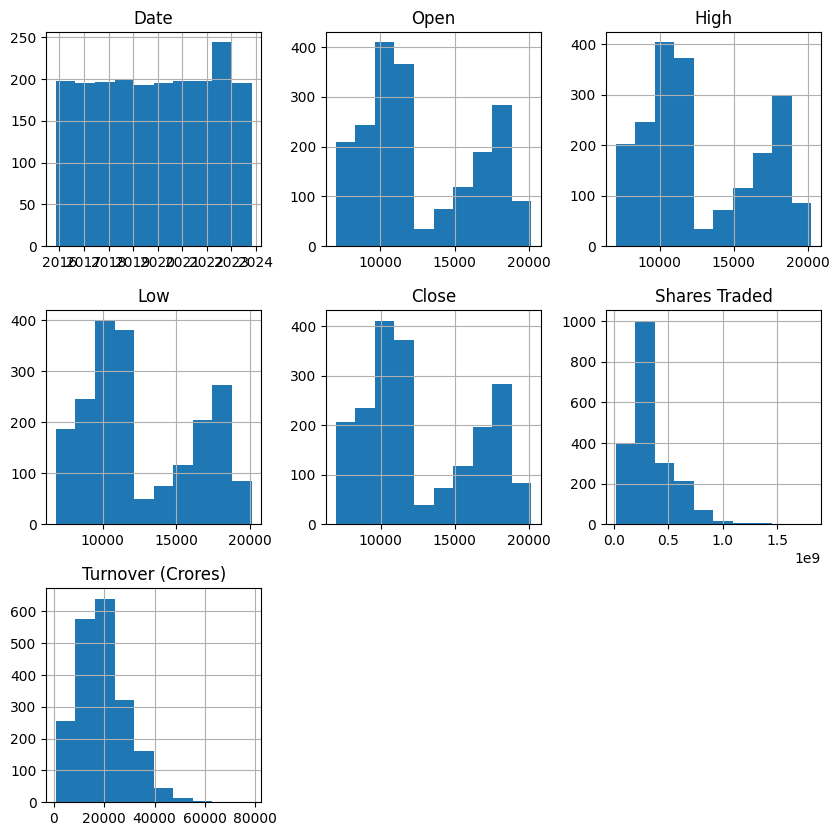

In [6]:
#show distributions in each column
df.hist(figsize=(10,10))
plt.show()

The histograms provide insights into the distribution of data across each column. The `Date` column exhibits a uniform distribution across the entire range, indicating that the stock market data covers the entire 5-year period. The `Open`, `High`, `Low`, and `Close` columns show similar distributions, with a peak in the middle and decreasing values towards the edges, suggesting a generally stable stock price with occasional fluctuations. The `Shares Traded` and `Turnover (₹ Cr)` columns exhibit right-skewed distributions, with a few data points corresponding to very high trading volumes and turnover values, a typical characteristic of stock market data.

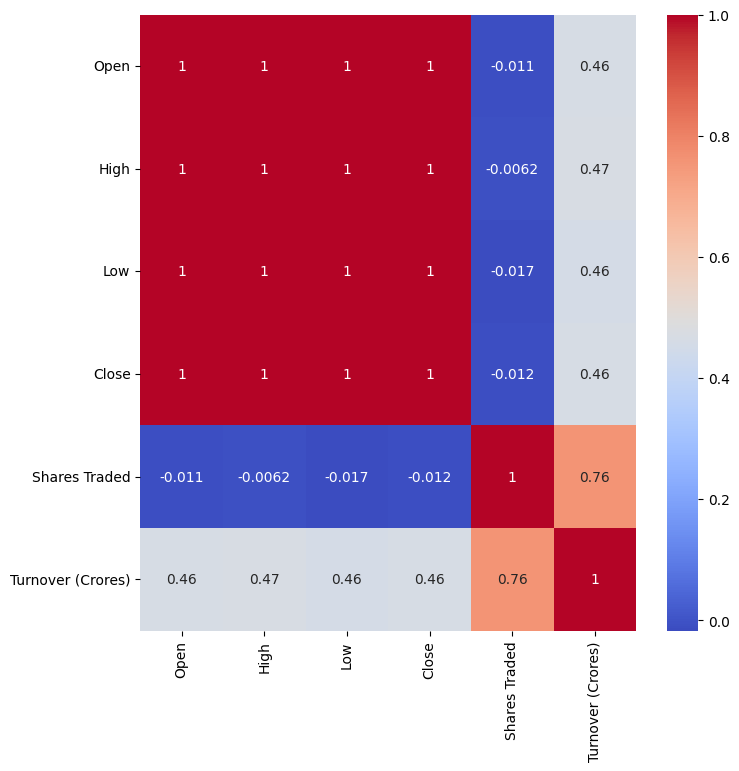

In [7]:
#plot a correlation matrix
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

Observations reveal strong positive correlations between `Open`, `High`, `Low`, and `Close`, unsurprising given their relationship to the stock price. A moderate positive correlation exists between `Shares Traded` and `Turnover (₹ Cr)`, suggesting an increase in trading volume alongside a rise in total traded value. A weak positive correlation between Date and other features indicates an overall upward trend in stock prices over the past 5 years.

In [8]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.update_layout(
    title='Stock Price Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    xaxis_rangeslider_visible=False
)

fig.show()

This candlestick chart suggest that there has been an overall growth of the stock across the observed time period, with a significant dip around March 2020, which is explained by the start of the Covid-19 pandemic, after that inital fall, recovery has been immense, reaching an all time high as early as late 2020, after whhich growth continued to accelerate, with occasional, but temporary drops.

------------
## Preprocessing
We use our learnings of the dataset from above to process all the data to a trainable format. 

In [9]:
def cleanup(df):
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [10]:
def preprocess(df):
    df = cleanup(df)
    if 'Date ' in df.columns: 
        df.rename(columns={"Date ":"Date"}, inplace=True) 
    if 'Open ' in df.columns: df.rename(columns={"Open ":"Open"}, inplace=True)
    if 'High ' in df.columns: df.rename(columns={"High ":"High"}, inplace=True)
    if 'Low ' in df.columns: df.rename(columns={"Low ":"Low"}, inplace=True)
    if 'Close ' in df.columns: df.rename(columns={"Close ":"Close"}, inplace=True)
    if 'Shares Traded ' in df.columns: df.rename(columns={"Shares Traded ":"Shares Traded"}, inplace=True)
    if 'Turnover (₹ Cr)' in df.columns: df.rename(columns={"Turnover (₹ Cr)":"Turnover (Crores)"}, inplace=True)
    
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y', errors='coerce')
    
    #Feature Engineering
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayofWeek'] = df['Date'].dt.dayofweek
    df['DayofYear'] = df['Date'].dt.dayofyear
    
    df['Open-Delta'] = df['Open'] - df['Open'].shift(1)
    """df['Open-Close'] = df['Open'] - df['Close']
    df['High-Low'] = df['High'] - df['Low']
    df['High-Delta'] = df['High'] - df['High'].shift(1)
    df['Low-Delta'] = df['Low'] - df['Low'].shift(1)
    df['Close-Open'] = df['Close'] - df['Open'].shift(1)
    df['Close-Delta'] = df['Close'] - df['Close'].shift(1)"""
    df['Volume-Delta'] = df['Shares Traded'] - df['Shares Traded'].shift(1)
    df['Turnover-Delta'] = df['Turnover (Crores)'] - df['Turnover (Crores)'].shift(1)
    
    #Replace NA values with 0 in the new columns
    df.fillna(0, inplace=True)
    df = cleanup(df)
    
    return df

df = preprocess(df)

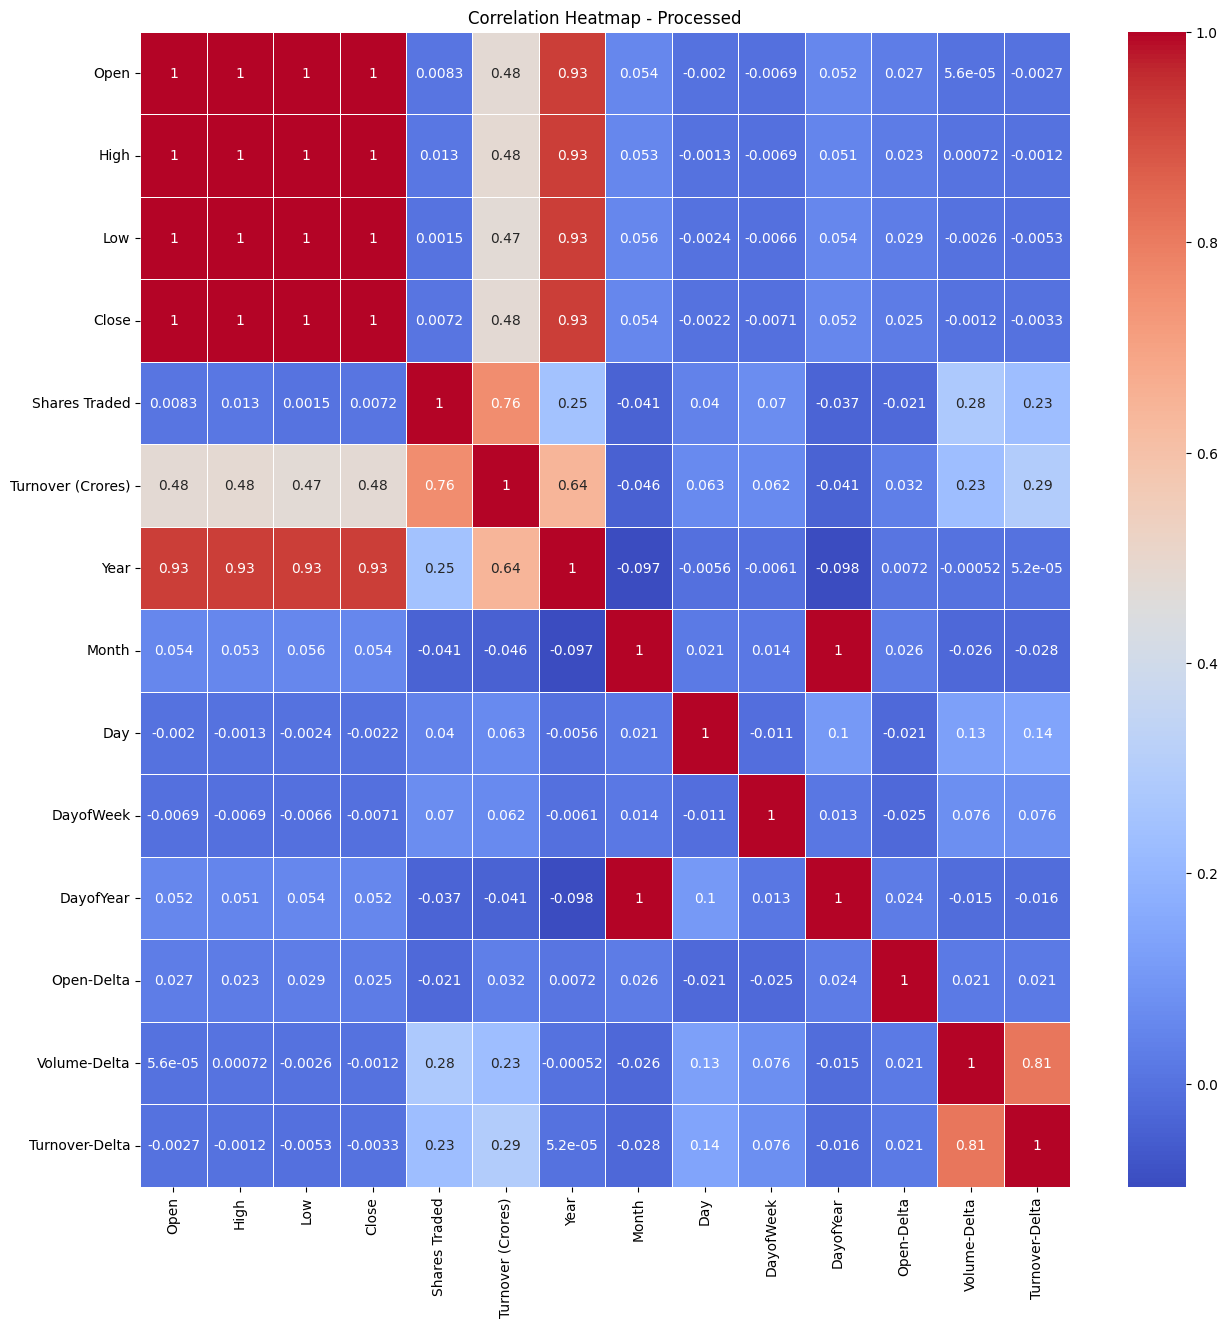

Most correlated features: {'Turnover-Delta', 'High', 'Open', 'DayofYear', 'Day', 'Volume-Delta', 'Shares Traded', 'Month', 'Year', 'Low', 'Turnover (Crores)', 'Close'}


In [11]:
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(len(df.columns),len(df.columns)))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap - Processed')
plt.show()

# Set the correlation threshold
correlation_threshold = 0.1  # Adjust this threshold as needed

# Create a set to store the highly correlated features
highly_correlated_features = set()

# Iterate through the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            # Add the feature names to the set
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            highly_correlated_features.add(feature_i)
            highly_correlated_features.add(feature_j)

# Print the highly correlated features
print("Most correlated features:", highly_correlated_features)

After preprocessing our data, we plot another correlation matrix to find the variables with correlation. We can see that `Volume-Delta`, `Low`, `High`, `Turnover (Crores)`, `Day`, `Open`, `Close`, `Year`, `Shares Traded`, `Month`, `Turnover-Delta`, and `DayofYear` are most correlated

--------------------------------
## Post Processing EDA
We re-examine our data to notice its current state, beforw it can be used in training.

Head:


Turnover-Delta     High     Open  DayofYear  Day  Volume-Delta  \
0            0.00  7937.75  7788.25        313    9           0.0   
1        -2222.70  7885.10  7877.60        314   10   -48154975.0   
2        -6030.03  7847.95  7838.80        315   11  -147886978.0   
3         6608.11  7775.10  7762.45        317   13   143496384.0   
4         -860.40  7838.85  7732.95        320   16   -11741934.0   
5         -504.01  7860.45  7848.75        321   17    -4683674.0   
6         -254.82  7843.40  7823.15        322   18    -1413490.0   
7         1297.83  7854.90  7788.50        323   19   -11335203.0   
8         -112.14  7906.95  7841.90        324   20    19907915.0   
9        -1198.92  7877.50  7869.50        327   23   -25738830.0   

   Shares Traded  Month  Year      Low  Turnover (Crores)    Close  
0    218422388.0     11  2015  7771.70            9376.17  7915.20  
1    170267413.0     11  2015  7772.85            7153.47  7783.35  
2     22380435.0     11  2015  7819.10            1123.44  7825.00  
3    165876819.0     11  2015  7730.90            7731.55  7762.25  
4    154134885.0     11  2015  7714.15            6871.15  7806.60  
5    149451211.0     11  2015  7793.00            6367.14  7837.55  
6    148037721.0     11  2015  7725.05            6112.32  7731.80  
7    136702518.0     11  2015  7765.45            7410.15  7842.75  
8    156610433.0     11  2015  7817.80            7298.01  7856.55  
9    130871603.0     11  2015  7825.20            6099.09  7849.25

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968 entries, 0 to 1967
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Turnover-Delta     1968 non-null   float64
 1   High               1968 non-null   float64
 2   Open               1968 non-null   float64
 3   DayofYear          1968 non-null   int64  
 4   Day                1968 non-null   int64  
 5   Volume-Delta       1968 non-null   float64
 6   Shares Traded      1968 non-null   float64
 7   Month              1968 non-null   int64  
 8   Year               1968 non-null   int64  
 9   Low                1968 non-null   float64
 10  Turnover (Crores)  1968 non-null   float64
 11  Close              1968 non-null   float64
dtypes: float64(8), int64(4)
memory usage: 184.6 KB
Info: None =========================
Description:


Turnover-Delta          High          Open    DayofYear          Day  \
count     1968.000000   1968.000000   1968.000000  1968.000000  1968.000000   
mean         3.922541  12716.040650  12657.759223   182.837398    15.792175   
std       5774.149620   3706.319535   3694.078689   105.781700     8.791143   
min     -46698.090000   7034.200000   7023.650000     1.000000     1.000000   
25%      -2107.727500   9945.300000   9907.900000    91.000000     8.000000   
50%        -65.370000  11435.125000  11384.925000   182.500000    16.000000   
75%       2120.332500  16590.175000  16481.612500   273.000000    23.000000   
max      49094.390000  20222.450000  20156.450000   366.000000    31.000000   

       Volume-Delta  Shares Traded        Month         Year           Low  \
count  1.968000e+03   1.968000e+03  1968.000000  1968.000000   1968.000000   
mean  -1.945625e+04   3.474974e+08     6.511179  2019.342480  12576.370401   
std    1.109404e+08   2.015752e+08     3.457179     2.313196   3676.232941   
min   -6.502488e+08   1.661087e+07     1.000000  2015.000000   6825.800000   
25%   -3.994546e+07   2.095937e+08     3.000000  2017.000000   9850.762500   
50%   -6.176065e+05   2.748260e+08     7.000000  2019.000000  11319.800000   
75%    3.908216e+07   4.431297e+08     9.000000  2021.000000  16381.150000   
max    7.899435e+08   1.811564e+09    12.000000  2023.000000  20129.700000   

       Turnover (Crores)         Close  
count        1968.000000   1968.000000  
mean        19390.168135  12647.978506  
std          9781.195357   3692.959631  
min           805.890000   6970.600000  
25%         11086.460000   9907.075000  
50%         18449.160000  11370.750000  
75%         24979.837500  16496.850000  
max         78522.930000  20192.350000

Null values
 Turnover-Delta       0
High                 0
Open                 0
DayofYear            0
Day                  0
Volume-Delta         0
Shares Traded        0
Month                0
Year                 0
Low                  0
Turnover (Crores)    0
Close                0
dtype: int64 
Dupicates: 0 


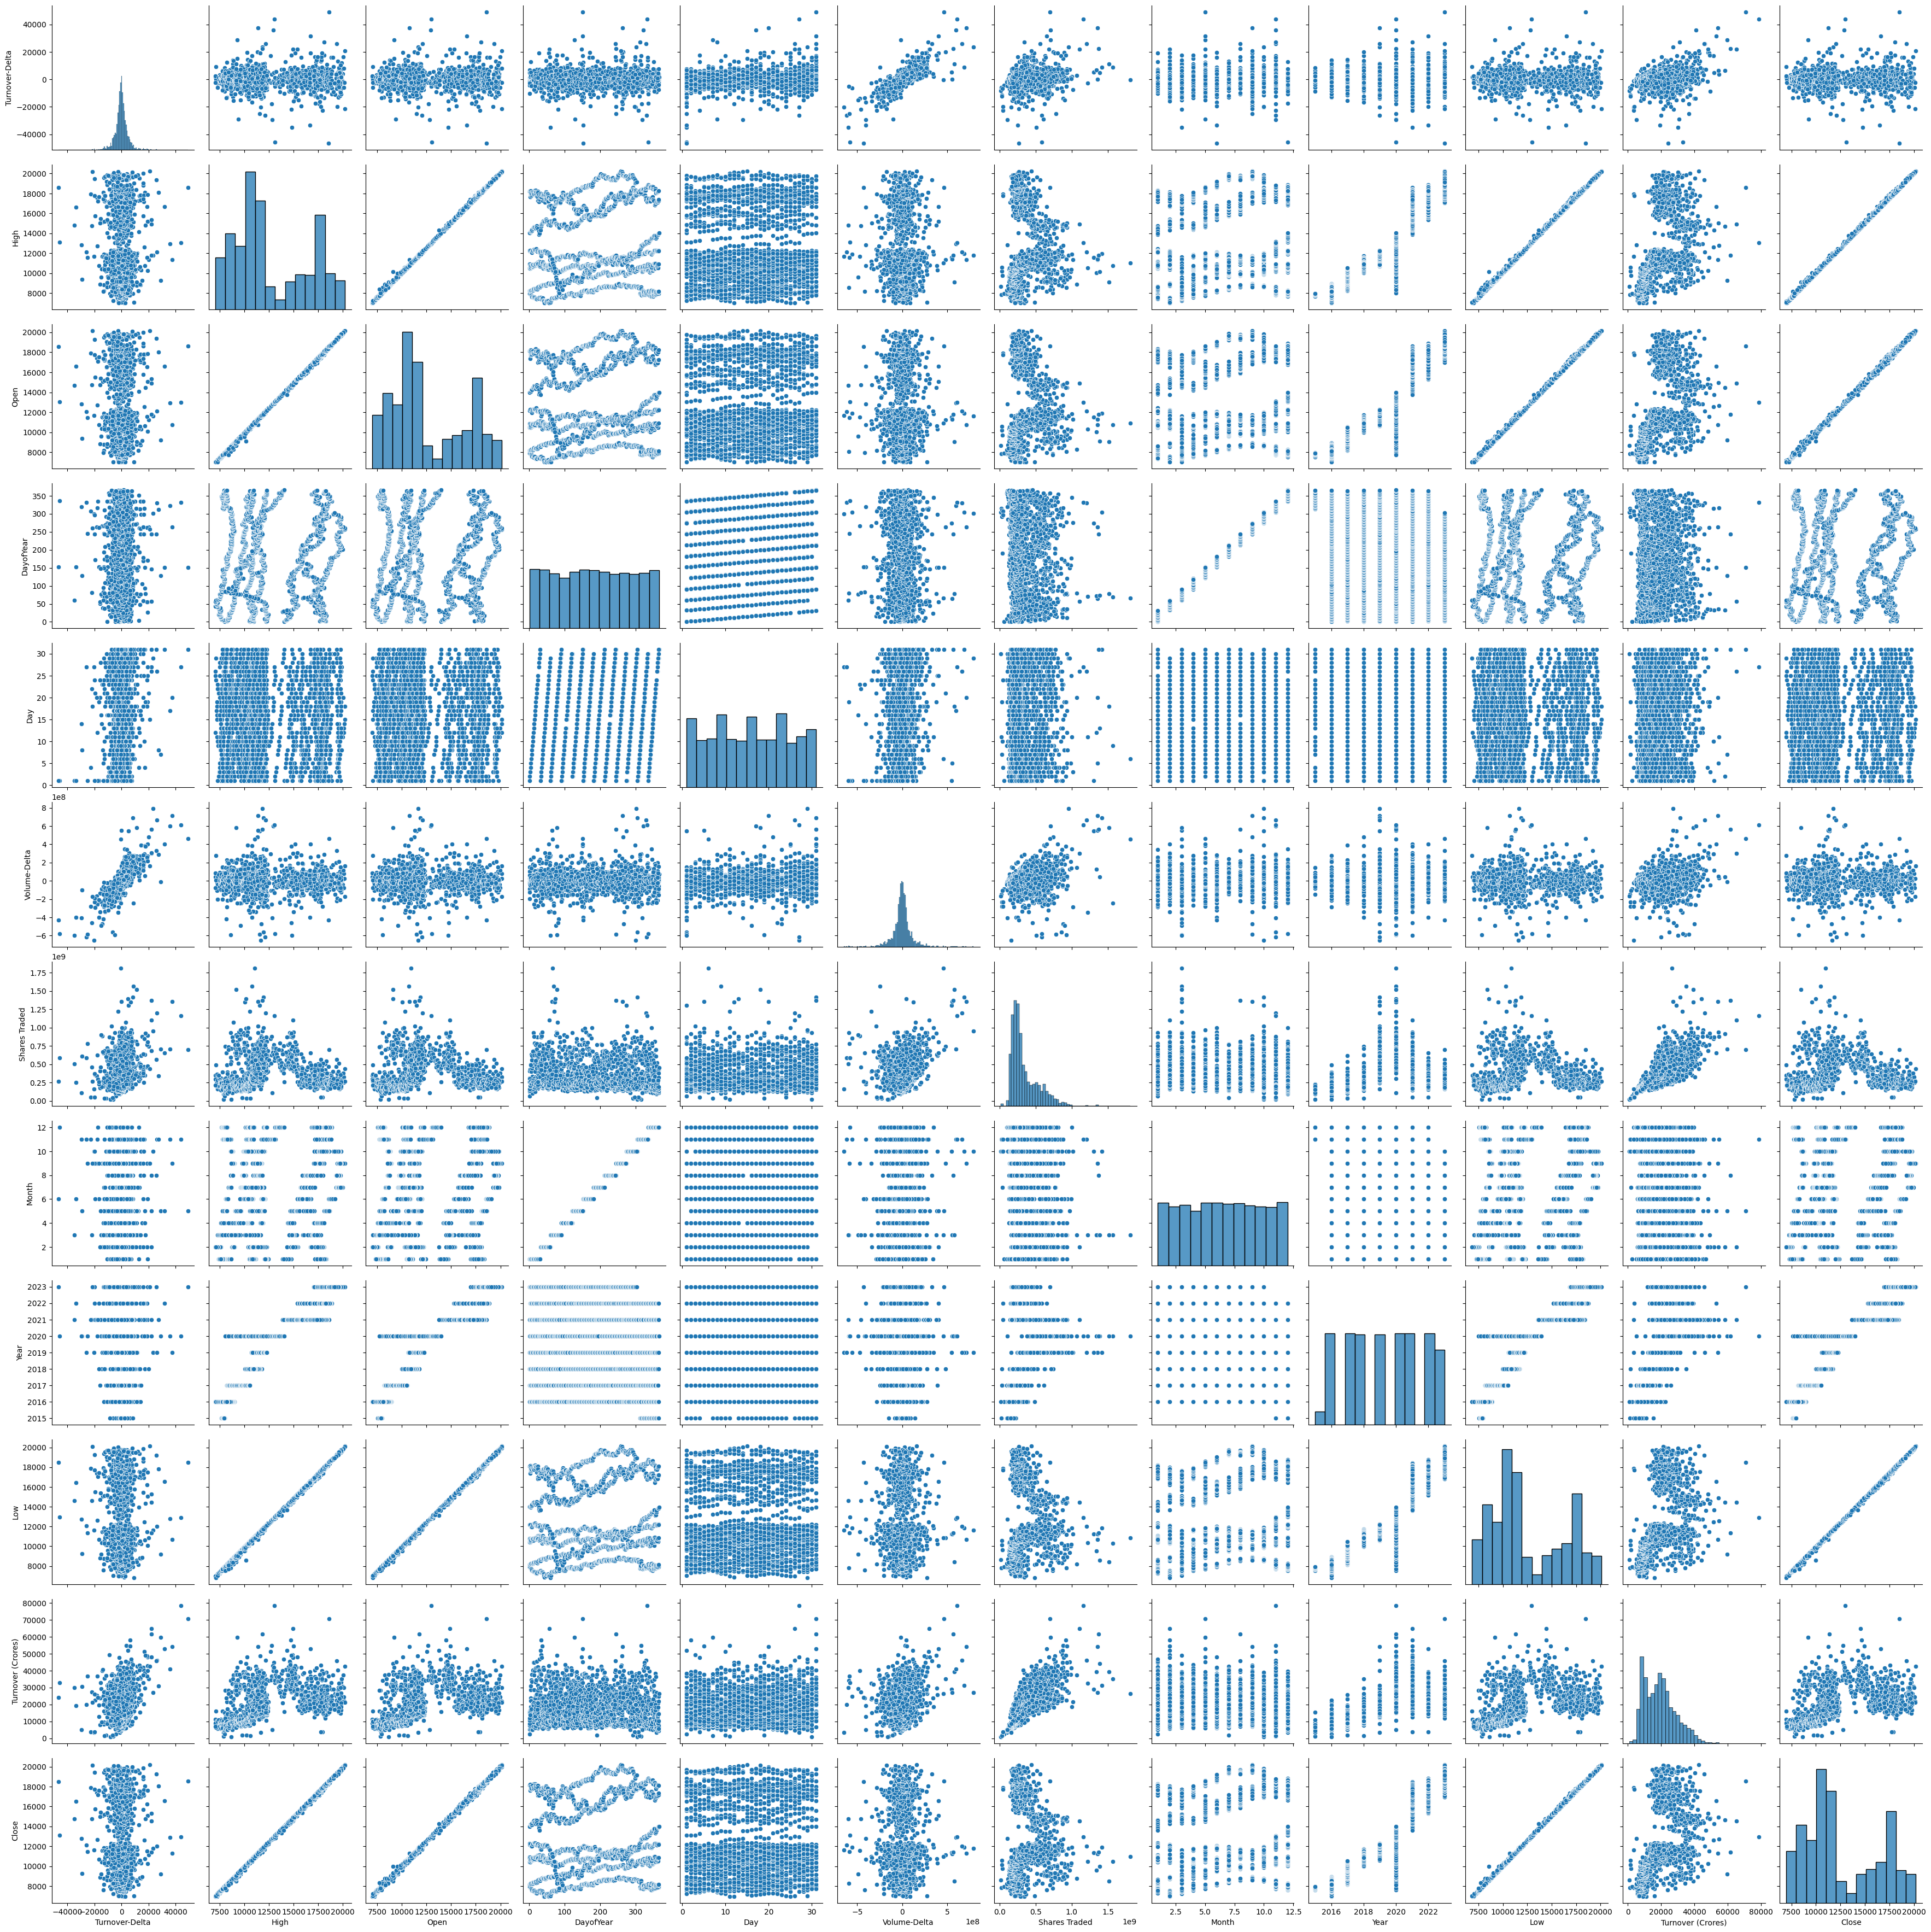

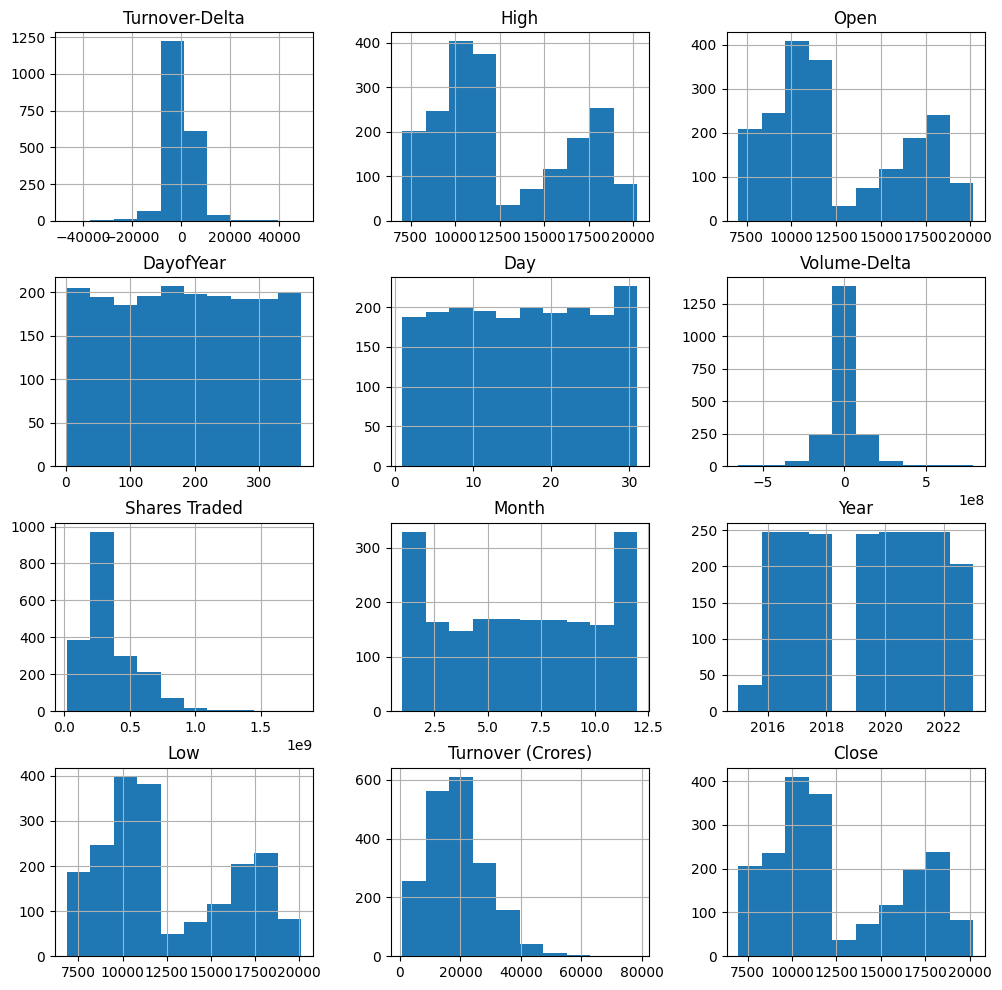

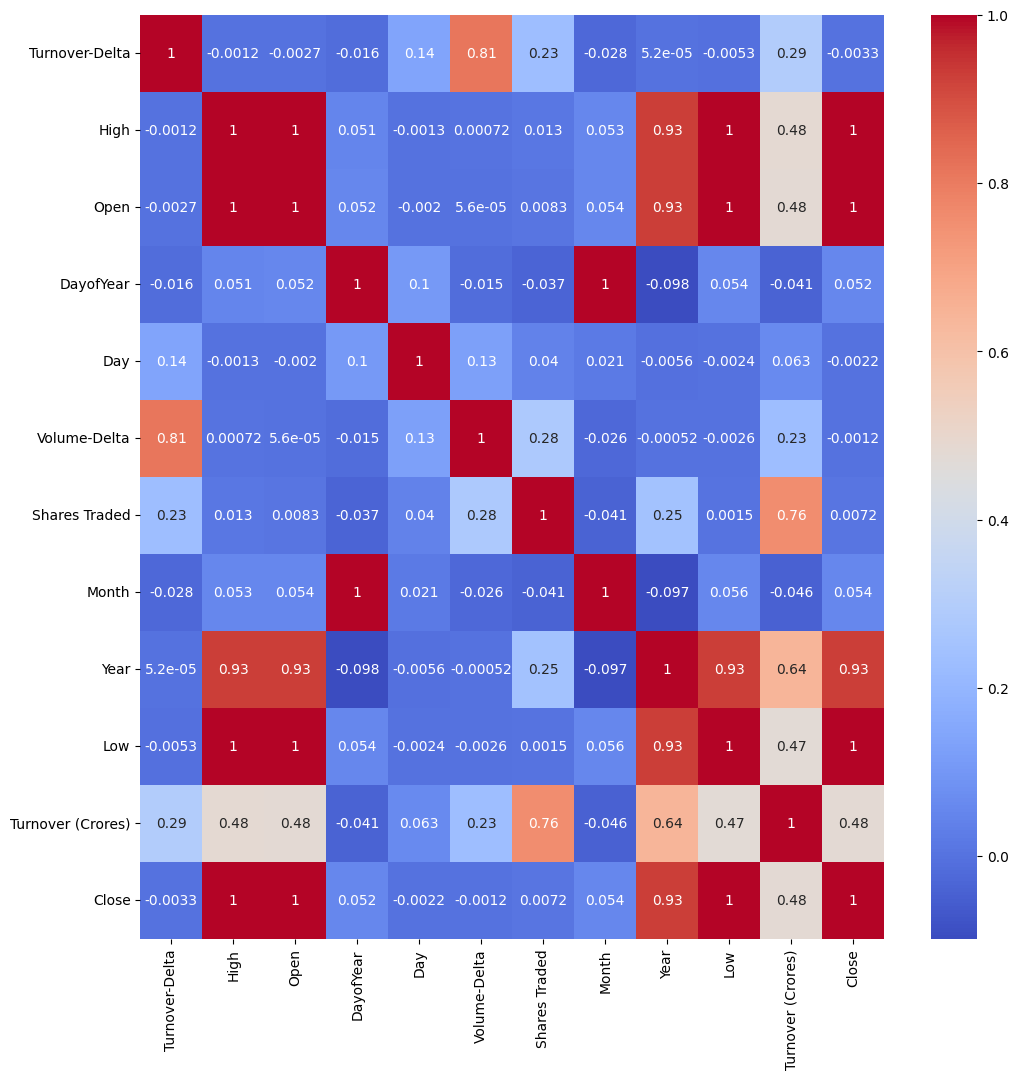

In [12]:
selected_features = list(set(highly_correlated_features).union(set(['High','Low','Close'])))
df = df[selected_features]
eda(df)

--------------------------------------------
## Training, Testing and Validation
We train the data on various models, sampling techniques and assess their performances

### Setup

In [13]:
#Splitting the dataset
X = df.drop(['High','Low','Close'], axis=1).copy()
y = df[['High','Low','Close']].copy()
eda(X, skipvisual=True)
eda(y, skipvisual=True)


Head:


Turnover-Delta     Open  DayofYear  Day  Volume-Delta  Shares Traded  \
0            0.00  7788.25        313    9           0.0    218422388.0   
1        -2222.70  7877.60        314   10   -48154975.0    170267413.0   
2        -6030.03  7838.80        315   11  -147886978.0     22380435.0   
3         6608.11  7762.45        317   13   143496384.0    165876819.0   
4         -860.40  7732.95        320   16   -11741934.0    154134885.0   
5         -504.01  7848.75        321   17    -4683674.0    149451211.0   
6         -254.82  7823.15        322   18    -1413490.0    148037721.0   
7         1297.83  7788.50        323   19   -11335203.0    136702518.0   
8         -112.14  7841.90        324   20    19907915.0    156610433.0   
9        -1198.92  7869.50        327   23   -25738830.0    130871603.0   

   Month  Year  Turnover (Crores)  
0     11  2015            9376.17  
1     11  2015            7153.47  
2     11  2015            1123.44  
3     11  2015            7731.55  
4     11  2015            6871.15  
5     11  2015            6367.14  
6     11  2015            6112.32  
7     11  2015            7410.15  
8     11  2015            7298.01  
9     11  2015            6099.09

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968 entries, 0 to 1967
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Turnover-Delta     1968 non-null   float64
 1   Open               1968 non-null   float64
 2   DayofYear          1968 non-null   int64  
 3   Day                1968 non-null   int64  
 4   Volume-Delta       1968 non-null   float64
 5   Shares Traded      1968 non-null   float64
 6   Month              1968 non-null   int64  
 7   Year               1968 non-null   int64  
 8   Turnover (Crores)  1968 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 138.5 KB
Info: None =========================
Description:


Turnover-Delta          Open    DayofYear          Day  Volume-Delta  \
count     1968.000000   1968.000000  1968.000000  1968.000000  1.968000e+03   
mean         3.922541  12657.759223   182.837398    15.792175 -1.945625e+04   
std       5774.149620   3694.078689   105.781700     8.791143  1.109404e+08   
min     -46698.090000   7023.650000     1.000000     1.000000 -6.502488e+08   
25%      -2107.727500   9907.900000    91.000000     8.000000 -3.994546e+07   
50%        -65.370000  11384.925000   182.500000    16.000000 -6.176065e+05   
75%       2120.332500  16481.612500   273.000000    23.000000  3.908216e+07   
max      49094.390000  20156.450000   366.000000    31.000000  7.899435e+08   

       Shares Traded        Month         Year  Turnover (Crores)  
count   1.968000e+03  1968.000000  1968.000000        1968.000000  
mean    3.474974e+08     6.511179  2019.342480       19390.168135  
std     2.015752e+08     3.457179     2.313196        9781.195357  
min     1.661087e+07     1.000000  2015.000000         805.890000  
25%     2.095937e+08     3.000000  2017.000000       11086.460000  
50%     2.748260e+08     7.000000  2019.000000       18449.160000  
75%     4.431297e+08     9.000000  2021.000000       24979.837500  
max     1.811564e+09    12.000000  2023.000000       78522.930000

Null values
 Turnover-Delta       0
Open                 0
DayofYear            0
Day                  0
Volume-Delta         0
Shares Traded        0
Month                0
Year                 0
Turnover (Crores)    0
dtype: int64 
Dupicates: 0 
Head:


High      Low    Close
0  7937.75  7771.70  7915.20
1  7885.10  7772.85  7783.35
2  7847.95  7819.10  7825.00
3  7775.10  7730.90  7762.25
4  7838.85  7714.15  7806.60
5  7860.45  7793.00  7837.55
6  7843.40  7725.05  7731.80
7  7854.90  7765.45  7842.75
8  7906.95  7817.80  7856.55
9  7877.50  7825.20  7849.25

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968 entries, 0 to 1967
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    1968 non-null   float64
 1   Low     1968 non-null   float64
 2   Close   1968 non-null   float64
dtypes: float64(3)
memory usage: 46.2 KB
Info: None =========================
Description:


High           Low         Close
count   1968.000000   1968.000000   1968.000000
mean   12716.040650  12576.370401  12647.978506
std     3706.319535   3676.232941   3692.959631
min     7034.200000   6825.800000   6970.600000
25%     9945.300000   9850.762500   9907.075000
50%    11435.125000  11319.800000  11370.750000
75%    16590.175000  16381.150000  16496.850000
max    20222.450000  20129.700000  20192.350000

Null values
 High     0
Low      0
Close    0
dtype: int64 
Dupicates: 0 


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:",X_train.shape,"y_train:",y_train.shape,"X_test:",X_test.shape,"y_test:",y_test.shape)

best_model_overall = None
best_model_name_overall = None
best_rmse_overall = float('inf')

X_train: (1574, 9) y_train: (1574, 3) X_test: (394, 9) y_test: (394, 3)


### Direct training

In [15]:
#importing models that can handle regression across multiple target variables
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, MultiTaskElasticNet
from xgboost import XGBRegressor

models = [
    (MultiOutputRegressor(RandomForestRegressor(random_state=42)), 'Random Forest Regressor'),
    (MultiOutputRegressor(GradientBoostingRegressor(random_state=42)), 'Gradient Boosting Regressor'),
    (MultiOutputRegressor(KNeighborsRegressor()), 'K Neighbors Regressor'),
    (MultiOutputRegressor(LinearRegression()), 'Linear Regression'),
    (MultiOutputRegressor(XGBRegressor(random_state=42)), 'XGB Regressor'),
    (MultiOutputRegressor(AdaBoostRegressor(random_state=42)), 'AdaBoost Regressor'),
    (MultiTaskElasticNet(random_state=42), 'MultiTaskElasticNet') 
]

# Evaluate and print model performance
for model, model_name in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    y_pred_df = pd.DataFrame(y_pred, columns=['High', 'Low', 'Close'])
    y_test_reset = y_test.reset_index(drop=True)
    y_pred_df_reset = y_pred_df.reset_index(drop=True)
    result_df = pd.concat([y_test_reset, y_pred_df_reset], axis=1, keys=['Original', 'Prediction'])
    columns = pd.MultiIndex.from_product([['Original', 'Prediction'], ['High', 'Low', 'Close']], names=['Type', 'Variable'])
    result_df.columns = columns
    display(result_df.head(5))

    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R-squared: {r2:.2f}")

    if rmse < best_rmse_overall: 
        best_model_overall = model
        best_rmse_overall = rmse
        best_model_name_overall = model_name

print(f"\nThe best model is {best_model_name_overall} with RMSE: {best_rmse_overall:.2f}")
best_change = "still"

Type      Original                      Prediction                        
Variable      High       Low     Close        High         Low       Close
0         11789.30  11699.55  11724.75  11765.0735  11656.7255  11706.6340
1         18061.25  17915.00  18017.20  18055.7490  17858.9945  17956.3355
2          7600.45   7541.25   7555.95   7618.7295   7455.3245   7510.5555
3          9404.40   9260.00   9380.90   9509.7495   9328.7455   9396.9050
4         11632.55  11571.35  11598.25  11647.2640  11545.6300  11606.7955

Random Forest Regressor - MAE: 64.04, RMSE: 93.15, R-squared: 1.00


Type      Original                        Prediction                \
Variable      High       Low     Close          High           Low   
0         11789.30  11699.55  11724.75  11737.295932  11639.798945   
1         18061.25  17915.00  18017.20  18046.652655  17880.352393   
2          7600.45   7541.25   7555.95   7632.349449   7507.247454   
3          9404.40   9260.00   9380.90   9509.954260   9352.064732   
4         11632.55  11571.35  11598.25  11646.712991  11559.759836   

Type                    
Variable         Close  
0         11703.044052  
1         17958.367892  
2          7579.871047  
3          9398.806891  
4         11602.030852

Gradient Boosting Regressor - MAE: 65.10, RMSE: 93.05, R-squared: 1.00


Type      Original                     Prediction                    
Variable      High       Low     Close       High       Low     Close
0         11789.30  11699.55  11724.75   14070.34  13909.27  13991.91
1         18061.25  17915.00  18017.20   15615.95  15456.39  15530.47
2          7600.45   7541.25   7555.95   10127.63  10054.50  10105.24
3          9404.40   9260.00   9380.90   12586.39  12471.69  12554.91
4         11632.55  11571.35  11598.25   13756.94  13598.74  13656.92

K Neighbors Regressor - MAE: 2846.40, RMSE: 3640.84, R-squared: 0.04


Type      Original                        Prediction                \
Variable      High       Low     Close          High           Low   
0         11789.30  11699.55  11724.75  11791.238928  11652.320457   
1         18061.25  17915.00  18017.20  18020.610408  17877.432590   
2          7600.45   7541.25   7555.95   7621.916454   7542.587223   
3          9404.40   9260.00   9380.90   9487.028823   9289.390684   
4         11632.55  11571.35  11598.25  11661.691610  11539.542034   

Type                    
Variable         Close  
0         11727.964930  
1         17951.373044  
2          7586.305272  
3          9391.438691  
4         11604.142182

Linear Regression - MAE: 56.93, RMSE: 82.51, R-squared: 1.00


Type      Original                        Prediction                \
Variable      High       Low     Close          High           Low   
0         11789.30  11699.55  11724.75  11707.350586  11576.494141   
1         18061.25  17915.00  18017.20  18064.199219  17876.099609   
2          7600.45   7541.25   7555.95   7609.866211   7525.232422   
3          9404.40   9260.00   9380.90   9460.193359   9322.243164   
4         11632.55  11571.35  11598.25  11663.928711  11599.416016   

Type                    
Variable         Close  
0         11651.956055  
1         18035.568359  
2          7516.882324  
3          9368.835938  
4         11634.737305

XGB Regressor - MAE: 74.61, RMSE: 106.82, R-squared: 1.00


Type      Original                        Prediction                \
Variable      High       Low     Close          High           Low   
0         11789.30  11699.55  11724.75  11636.348097  11586.278940   
1         18061.25  17915.00  18017.20  17976.714828  17974.089323   
2          7600.45   7541.25   7555.95   7740.614331   7536.005102   
3          9404.40   9260.00   9380.90   9445.083457   9121.325126   
4         11632.55  11571.35  11598.25  11607.169771  11526.130615   

Type                    
Variable         Close  
0         11608.364265  
1         17942.710360  
2          7565.396131  
3          9317.140909  
4         11593.378592

AdaBoost Regressor - MAE: 143.77, RMSE: 187.93, R-squared: 1.00


Type      Original                        Prediction                \
Variable      High       Low     Close          High           Low   
0         11789.30  11699.55  11724.75  11790.393420  11651.073591   
1         18061.25  17915.00  18017.20  18027.771899  17882.201190   
2          7600.45   7541.25   7555.95   7628.383992   7547.211754   
3          9404.40   9260.00   9380.90   9475.754149   9282.487255   
4         11632.55  11571.35  11598.25  11657.174117  11536.058809   

Type                    
Variable         Close  
0         11726.921948  
1         17958.428482  
2          7592.659613  
3          9380.414501  
4         11599.500215

MultiTaskElasticNet - MAE: 57.05, RMSE: 82.72, R-squared: 1.00

The best model is Linear Regression with RMSE: 82.51


### Hyperparameter Tuning

In [16]:
"""from sklearn.linear_model import LinearRegression

# Create a multi-output LinearRegression
linear_regression = LinearRegression()

# Grid Search
print("Starting Grid Search...")
start_time_grid = time.time()

# Perform grid search for each target variable separately
grid_search = GridSearchCV(estimator=linear_regression, param_grid={}, scoring='neg_mean_squared_error', cv=2, n_jobs=-1)

# Grid search for 'High' target
print("High:")
grid_search.fit(X_train, y_train['High'])
best_params_high = grid_search.best_params_
best_linear_regression_high = LinearRegression(**best_params_high)
best_linear_regression_high.fit(X_train, y_train['High'])
y_pred_high = best_linear_regression_high.predict(X_test)
display(pd.DataFrame({"Original": y_test['High'].values, "Predicted": y_pred_high}).head(5))

# Grid search for 'Low' target
print("Low:")
grid_search.fit(X_train, y_train['Low'])
best_params_low = grid_search.best_params_
best_linear_regression_low = LinearRegression(**best_params_low)
best_linear_regression_low.fit(X_train, y_train['Low'])
y_pred_low = best_linear_regression_low.predict(X_test)
display(pd.DataFrame({"Original": y_test['Low'].values, "Predicted": y_pred_low}).head(5))

# Grid search for 'Close' target
print("Closing:")
grid_search.fit(X_train, y_train['Close'])
best_params_close = grid_search.best_params_
best_linear_regression_close = LinearRegression(**best_params_close)
best_linear_regression_close.fit(X_train, y_train['Close'])
y_pred_close = best_linear_regression_close.predict(X_test)
display(pd.DataFrame({"Original": y_test['Close'].values, "Predicted": y_pred_close}).head(5))

# Combine predictions for evaluation
y_pred_multi_output = np.column_stack((y_pred_high, y_pred_low, y_pred_close))

# Evaluation metrics
mse_multi_output = mean_squared_error(y_test, y_pred_multi_output)
mae_multi_output = mean_absolute_error(y_test, y_pred_multi_output)
rmse_multi_output = np.sqrt(mse_multi_output)
r2_multi_output = r2_score(y_test, y_pred_multi_output)

end_time_grid = time.time()
print(f"Grid Search completed in {end_time_grid - start_time_grid:.2f} seconds")

# Display results
print("Net resuts:")
print(f"MSE (Multi-Output): {mse_multi_output}")
print(f"MAE (Multi-Output): {mae_multi_output}")
print(f"RMSE (Multi-Output): {rmse_multi_output}")
print(f"R2 Score (Multi-Output): {r2_multi_output}")

best_change = "still"
if rmse_multi_output<best_rmse_overall:
    best_change = "now"
    best_rmse_overall = rmse_multi_output
    best_model_overall = best_linear_regression_high
    best_model_name_overall = 'Linear Regression (Grid Search)'

y_pred_df = pd.DataFrame(y_pred_multi_output, columns=['High', 'Low', 'Close'])
y_test_reset = y_test.reset_index(drop=True)
y_pred_df_reset = y_pred_df.reset_index(drop=True)
result_df = pd.concat([y_test_reset, y_pred_df_reset], axis=1, keys=['Original', 'Prediction'])
columns = pd.MultiIndex.from_product([['Original', 'Prediction'], ['High', 'Low', 'Close']], names=['Type', 'Variable'])
result_df.columns = columns
display(result_df.head(5))"""

'from sklearn.linear_model import LinearRegression\n\n# Create a multi-output LinearRegression\nlinear_regression = LinearRegression()\n\n# Grid Search\nprint("Starting Grid Search...")\nstart_time_grid = time.time()\n\n# Perform grid search for each target variable separately\ngrid_search = GridSearchCV(estimator=linear_regression, param_grid={}, scoring=\'neg_mean_squared_error\', cv=2, n_jobs=-1)\n\n# Grid search for \'High\' target\nprint("High:")\ngrid_search.fit(X_train, y_train[\'High\'])\nbest_params_high = grid_search.best_params_\nbest_linear_regression_high = LinearRegression(**best_params_high)\nbest_linear_regression_high.fit(X_train, y_train[\'High\'])\ny_pred_high = best_linear_regression_high.predict(X_test)\ndisplay(pd.DataFrame({"Original": y_test[\'High\'].values, "Predicted": y_pred_high}).head(5))\n\n# Grid search for \'Low\' target\nprint("Low:")\ngrid_search.fit(X_train, y_train[\'Low\'])\nbest_params_low = grid_search.best_params_\nbest_linear_regression_low = L

In [17]:
"""# Randomized Search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

linear_regression = LinearRegression()

print("Starting Randomized Search...")
start_time_random = time.time()

random_search = RandomizedSearchCV(estimator=linear_regression, param_distributions={}, n_iter=1, scoring='neg_mean_squared_error', cv=2, n_jobs=-1)

#Random search for 'High' target
print("High:")
random_search.fit(X_train, y_train['High'])
best_params_high_random = random_search.best_params_
best_linear_regression_high_random = LinearRegression(**best_params_high_random)
best_linear_regression_high_random.fit(X_train, y_train['High'])
y_pred_high_random = best_linear_regression_high_random.predict(X_test)
display(pd.DataFrame({"Original": y_test['High'].values, "Predicted": y_pred_high_random}).head(5))

# Random search for 'Low' target
print("Low:")
random_search.fit(X_train, y_train['Low'])
best_params_low_random = random_search.best_params_
best_linear_regression_low_random = LinearRegression(**best_params_low_random)
best_linear_regression_low_random.fit(X_train, y_train['Low'])
y_pred_low_random = best_linear_regression_low_random.predict(X_test)
display(pd.DataFrame({"Original": y_test['Low'].values, "Predicted": y_pred_low_random}).head(5))

# Random search for 'Close' target
print("Closing:")
random_search.fit(X_train, y_train['Close'])
best_params_close_random = random_search.best_params_
best_linear_regression_close_random = LinearRegression(**best_params_close_random)
best_linear_regression_close_random.fit(X_train, y_train['Close'])
y_pred_close_random = best_linear_regression_close_random.predict(X_test)
display(pd.DataFrame({"Original": y_test['Close'].values, "Predicted": y_pred_close_random}).head(5))

# Combine predictions for evaluation
y_pred_multi_output_random = np.column_stack((y_pred_high_random, y_pred_low_random, y_pred_close_random))

# Evaluation metrics
mse_multi_output_random = mean_squared_error(y_test, y_pred_multi_output_random)
mae_multi_output_random = mean_absolute_error(y_test, y_pred_multi_output_random)
rmse_multi_output_random = np.sqrt(mse_multi_output_random)
r2_multi_output_random = r2_score(y_test, y_pred_multi_output_random)

end_time_random = time.time()
print(f"Randomized Search completed in {end_time_random - start_time_random:.2f} seconds")

# Display results
print("Net Results:")
print(f"MSE (Multi-Output - Randomized Search): {mse_multi_output_random}")
print(f"MAE (Multi-Output - Randomized Search): {mae_multi_output_random}")
print(f"RMSE (Multi-Output - Randomized Search): {rmse_multi_output_random}")
print(f"R2 Score (Multi-Output - Randomized Search): {r2_multi_output_random}")

if rmse_multi_output_random < best_rmse_overall:
    best_change = "now"
    best_rmse_overall = rmse_multi_output_random
    best_model_overall = best_linear_regression_high_random
    best_model_name_overall = 'Linear Regression (Randomized Search)'

y_pred_df_random = pd.DataFrame(y_pred_multi_output_random, columns=['High', 'Low', 'Close'])
y_test_reset_random = y_test.reset_index(drop=True)
y_pred_df_reset_random = y_pred_df_random.reset_index(drop=True)
result_df_random = pd.concat([y_test_reset_random, y_pred_df_reset_random], axis=1, keys=['Original', 'Prediction'])
columns_random = pd.MultiIndex.from_product([['Original', 'Prediction'], ['High', 'Low', 'Close']], names=['Type', 'Variable'])
result_df_random.columns = columns_random
display(result_df_random.head(5))

print(f"The best model is {best_change} {best_model_name_overall} with RMSE: {best_rmse_overall:.2f}")
best_change = "still"
"""

'# Randomized Search\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform\n\nlinear_regression = LinearRegression()\n\nprint("Starting Randomized Search...")\nstart_time_random = time.time()\n\nrandom_search = RandomizedSearchCV(estimator=linear_regression, param_distributions={}, n_iter=1, scoring=\'neg_mean_squared_error\', cv=2, n_jobs=-1)\n\n#Random search for \'High\' target\nprint("High:")\nrandom_search.fit(X_train, y_train[\'High\'])\nbest_params_high_random = random_search.best_params_\nbest_linear_regression_high_random = LinearRegression(**best_params_high_random)\nbest_linear_regression_high_random.fit(X_train, y_train[\'High\'])\ny_pred_high_random = best_linear_regression_high_random.predict(X_test)\ndisplay(pd.DataFrame({"Original": y_test[\'High\'].values, "Predicted": y_pred_high_random}).head(5))\n\n# Random search for \'Low\' target\nprint("Low:")\nrandom_search.fit(X_train, y_train[\'Low\'])\nbest_params_low_random = random_search

### Cross Validation

In [18]:
from sklearn.model_selection import cross_val_score

# Evaluate models using cross-validation
for model, model_name in models:
    # Calculate RMSE for each target variable separately
    cv_scores = np.sqrt(-cross_val_score(model, X, y, cv=2, scoring='neg_mean_squared_error', error_score='raise'))
    
    # Convert negative mean squared error to positive (for consistency)
    #cv_scores = np.sqrt(-cv_scores)
    
    # Calculate metrics
    rmse_cv = np.mean(cv_scores)
    mae_cv = np.mean(-cross_val_score(model, X, y, cv=2, scoring='neg_mean_absolute_error'))
    r2_cv = np.mean(cross_val_score(model, X, y, cv=2, scoring='r2'))
    
    print(f"Model: {model_name}")
    print(f"Cross-Validation RMSE: {rmse_cv:.2f}")
    print(f"Cross-Validation MAE: {mae_cv:.2f}")
    print(f"Cross-Validation R-squared: {r2_cv:.2f}")
    print("============================")
    
    # Check if the RMSE is better than the current best
    if rmse_cv < best_rmse_overall:
        best_change = "now"
        best_model_overall = model
        best_rmse_overall = rmse_cv
        best_model_name_overall = model_name + " (Cross-Validation)"

print(f"The best model is {best_change} {best_model_name_overall} with RMSE: {best_rmse_overall:.2f}")

Model: Random Forest Regressor
Cross-Validation RMSE: 2439.19
Cross-Validation MAE: 2004.22
Cross-Validation R-squared: -0.17
Model: Gradient Boosting Regressor
Cross-Validation RMSE: 2426.92
Cross-Validation MAE: 1975.89
Cross-Validation R-squared: -0.16
Model: K Neighbors Regressor
Cross-Validation RMSE: 7008.43
Cross-Validation MAE: 6388.41
Cross-Validation R-squared: -18.30
Model: Linear Regression
Cross-Validation RMSE: 88.78
Cross-Validation MAE: 65.35
Cross-Validation R-squared: 1.00
Model: XGB Regressor
Cross-Validation RMSE: 2498.06
Cross-Validation MAE: 2037.36
Cross-Validation R-squared: -0.20
Model: AdaBoost Regressor
Cross-Validation RMSE: 2517.53
Cross-Validation MAE: 2076.46
Cross-Validation R-squared: -0.23
Model: MultiTaskElasticNet
Cross-Validation RMSE: 84.55
Cross-Validation MAE: 60.63
Cross-Validation R-squared: 1.00
The best model is still Linear Regression with RMSE: 82.51


In [19]:
import joblib
joblib.dump(best_model_overall, 'stock_model.pkl')

['stock_model.pkl']

------------
## Testing Against Sample data
We sample 100 random rows from the dataset to see how the model predicts the appointment time

In [20]:
data = pd.read_csv("StockMarketData2015-2023.csv")
data = preprocess(data)
# Select random rows
random_rows = data.sample(n=100, random_state=42)

random_rows = random_rows[selected_features]
random_rows = cleanup(random_rows)

X_random = random_rows.drop(['High','Low','Close'], axis=1).copy()
y_random = random_rows[['High','Low','Close']].copy()

# Predict using the best model
y_pred = best_model_overall.predict(X_random)

rmse_random = mean_squared_error(y_random, y_pred, squared=False)
mse_random = mean_squared_error(y_random, y_pred)
mae_random = mean_absolute_error(y_random, y_pred)
r2_random = r2_score(y_random, y_pred)

print(f"Root Mean Squared Error for the 10 random predictions: {rmse_random:.2f}")
print(f"Mean Squared Error for the 10 random predictions: {mse_random:.2f}")
print(f"Mean Absolute Error for the 10 random predictions: {mae_random:.2f}")
print(f"R-squared for the 10 random predictions: {r2_random:.2f}")

y_pred_df = pd.DataFrame(y_pred, columns=['High', 'Low', 'Close'])
y_test_reset = y_random.reset_index(drop=True)
y_pred_df_reset = y_pred_df.reset_index(drop=True)
y_diff = abs(y_test_reset - y_pred_df_reset)
y_diff = y_diff.round(5)

result_df = pd.concat([y_test_reset, y_pred_df_reset, y_diff], axis=1, keys=['Original', 'Prediction', 'Delta'])
columns = pd.MultiIndex.from_product([['Original', 'Prediction','Delta'], ['High', 'Low', 'Close']], names=['Type', 'Variable'])
result_df.columns = columns
display(result_df.head(5))

Root Mean Squared Error for the 10 random predictions: 73.06
Mean Squared Error for the 10 random predictions: 5630.22
Mean Absolute Error for the 10 random predictions: 53.58
R-squared for the 10 random predictions: 1.00


Type      Original                        Prediction                \
Variable      High       Low     Close          High           Low   
0         11789.30  11699.55  11724.75  11791.238928  11652.320457   
1         18061.25  17915.00  18017.20  18020.610408  17877.432590   
2          7600.45   7541.25   7555.95   7621.916454   7542.587223   
3          9404.40   9260.00   9380.90   9487.028823   9289.390684   
4         11632.55  11571.35  11598.25  11661.691610  11539.542034   

Type                       Delta                      
Variable         Close      High       Low     Close  
0         11727.964930   1.93893  47.22954   3.21493  
1         17951.373044  40.63959  37.56741  65.82696  
2          7586.305272  21.46645   1.33722  30.35527  
3          9391.438691  82.62882  29.39068  10.53869  
4         11604.142182  29.14161  31.80797   5.89218

In [21]:
total_end = time.time()
total_time = int(total_end - total_start)
print(f"Total time elapsed: {total_time//60}m {total_time%60}s")

Total time elapsed: 0m 49s


----------
## Conclusion
We can see that after performing various techniques of training, the best possible results are given by Linear Regression with RMSE: 82.51. Upon sampling 100 random rows, we can see it similarly produces results within a 80 point error.